In [1]:
import numpy as np
from scipy.integrate import quad
import emcee
import matplotlib.pyplot as plt
import corner
from tqdm import tqdm

### Data and Parameters

In [2]:
# Redshift (z)
z_data = np.array([0.9, 1.2, 1.5])

# Angular diameter distances and errors [Mpc]
dA_data = np.array([1688, 1781, 1793])
dA_err  = np.array([47, 46, 28])

# Hubble parameter and errors [km/s/Mpc]
H_data = np.array([112.1, 136.9, 154.7])
H_err  = np.array([3.8,   5.7,   6.0])

In [3]:
c = 299792.458          # speed of light [km/s]
H0 = 67                 # Hubble constant [km/s/Mpc]
Omega_m = 0.319         # Omega matter
Omega_de = 1 - Omega_m  # Omega dark energy

### Markov Chain Monte Carlo

Functions to calculate H and $d_A$

In [4]:
# Hubble Parameter
def hubble(z, w0, wa, H0, Omega_m, Omega_de):
    term1 = Omega_m * (1 + z)**3
    exponent = 3 * (1 + w0 + wa)
    term2 = Omega_de * (1 + z)**exponent * np.exp(-3 * wa * z / (1 + z))
    return H0 * np.sqrt(term1 + term2)

# Angular diameter distance
def angular_diameter_distance(z_array, w0, wa, H0, Omega_m, Omega_de, c):
    def integrand(zp, w0, wa, H0, Omega_m, Omega_de):
        return c / hubble(zp, w0, wa, H0, Omega_m, Omega_de)

    results = []
    for z in np.atleast_1d(z_array):
        integral, _ = quad(integrand, 0, z, args=(w0, wa, H0, Omega_m, Omega_de))
        dA = integral / (1 + z)
        results.append(dA)

    return np.array(results)

# Get functions that only take as arguments the parameters we actually want to optimize over
hubble_fit_func = lambda z, w0, wa: hubble(z=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de)
dA_fit_func     = lambda z, w0, wa: angular_diameter_distance(z_array=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de, c=c)

Define functions needed for MCMC

In [5]:
def log_likelihood(theta):
    w0, wa = theta
    H_model = hubble_fit_func(z_data, w0, wa)
    dA_model = dA_fit_func(z_data, w0, wa)

    chi2_H = np.sum(((H_data - H_model) / H_err) ** 2)
    chi2_dA = np.sum(((dA_data - dA_model) / dA_err) ** 2)

    return -0.5 * (chi2_H + chi2_dA)

# Define prior (uniform distribution within search area)
def log_prior(theta):
    w0, wa = theta
    if -5 < w0 < 1 and -6 < wa < 5: # search area
        return 0.0  # flat prior = constant log prior
    return -np.inf  # log(0), SET TO 0 FOR UNBOUNDED SEARCH

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

Run MCMC

In [6]:
# Params
ndim = 2
nwalkers = 32
nsteps = 5000

# Initial guess
p0 = np.array([-1.0, 0.0])
initial_positions = p0 + 1e-2 * np.random.randn(nwalkers, ndim)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(initial_positions, nsteps, progress=True)

100%|██████████| 5000/5000 [00:13<00:00, 379.26it/s]


State([[-1.15835117  0.64704659]
 [-0.44002978 -2.46327268]
 [-0.97441006  0.08951819]
 [-1.07918904 -0.18559376]
 [-0.91490493 -0.53570159]
 [-0.64191087 -1.79474823]
 [-0.44391595 -2.64542886]
 [-0.57488569 -2.10477964]
 [-1.05135317  0.15771201]
 [-0.42978645 -2.49029238]
 [-1.22286967  0.30997246]
 [-1.0525379  -0.05080498]
 [-0.74847209 -1.06561418]
 [-0.7634231  -1.63285017]
 [-0.68723795 -1.14088982]
 [-0.78497408 -0.81016732]
 [-1.06295999  0.10049147]
 [-0.96343706 -0.45777367]
 [-0.58645317 -1.45532576]
 [-1.20505046  0.96227302]
 [-1.11706861  0.46479784]
 [-0.57823825 -2.01451776]
 [-0.97980205 -0.08898567]
 [-0.6033037  -2.07227263]
 [-0.87590459 -0.53122845]
 [-0.80854697 -1.10026206]
 [-0.8922571  -0.62456797]
 [-0.63829053 -1.39240309]
 [-0.94879223 -0.58765506]
 [-1.12845079  0.41859505]
 [-1.08939643  0.49403919]
 [-1.02676014  0.09911945]], log_prob=[-0.8477431  -2.33054511 -1.44529961 -1.75715999 -0.56852512 -1.170529
 -1.98221811 -1.40999911 -0.59610599 -2.44415378

Get results and plot them. Use median $\pm$ credible interval (most common in astro/cosmo)

w0 = -0.899 (+0.328/-0.271)
wa = -0.599 (+1.185/-1.557)


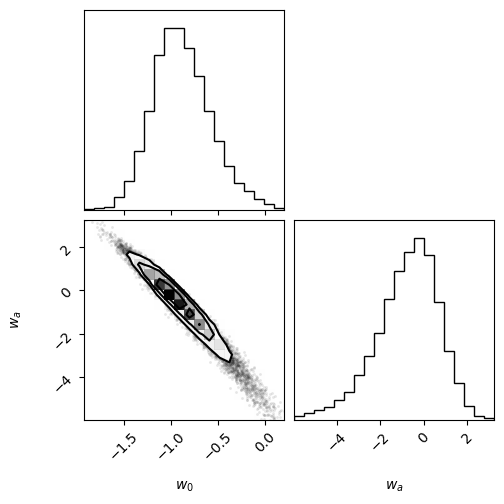

In [7]:
samples = sampler.get_chain(discard=1000, thin=10, flat=True)

w0_16, w0_50, w0_84 = np.percentile(samples[:, 0], [16, 50, 84])
wa_16, wa_50, wa_84 = np.percentile(samples[:, 1], [16, 50, 84])

print(f"w0 = {w0_50:.3f} (+{w0_84 - w0_50:.3f}/-{w0_50 - w0_16:.3f})")
print(f"wa = {wa_50:.3f} (+{wa_84 - wa_50:.3f}/-{wa_50 - wa_16:.3f})")

fig = corner.corner(samples, labels=[r"$w_0$", r"$w_a$"], truths=[None, None])
plt.show()

Plot results of fit

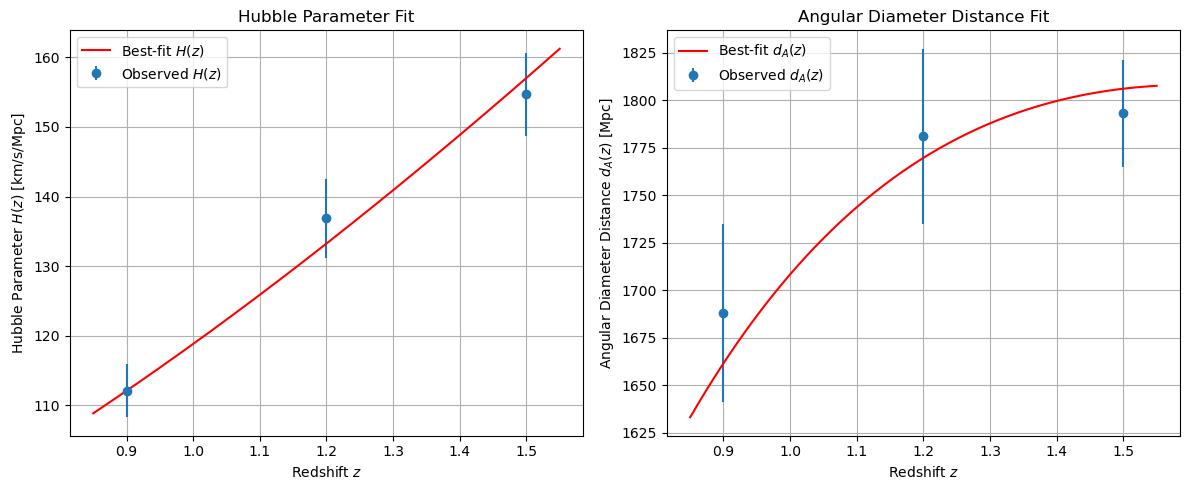

In [8]:
# Best-fit parameters
w0_best, wa_best = np.median(samples, axis=0)

# Dense redshift sampling for smooth curves
z_dense = np.linspace(min(z_data) - 0.05, max(z_data) + 0.05, 300)

# Evaluate model on dense grid
H_model_dense = hubble_fit_func(z_dense, w0_best, wa_best)
dA_model_dense = dA_fit_func(z_dense, w0_best, wa_best)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# H(z)
ax1.errorbar(z_data, H_data, yerr=H_err, fmt='o', label="Observed $H(z)$")
ax1.plot(z_dense, H_model_dense, '-', color='red', label="Best-fit $H(z)$")
ax1.set_xlabel("Redshift $z$")
ax1.set_ylabel("Hubble Parameter $H(z)$ [km/s/Mpc]")
ax1.set_title("Hubble Parameter Fit")
ax1.legend()
ax1.grid(True)

# d_A(z)
ax2.errorbar(z_data, dA_data, yerr=dA_err, fmt='o', label="Observed $d_A(z)$")
ax2.plot(z_dense, dA_model_dense, '-', color='red', label="Best-fit $d_A(z)$")
ax2.set_xlabel("Redshift $z$")
ax2.set_ylabel("Angular Diameter Distance $d_A(z)$ [Mpc]")
ax2.set_title("Angular Diameter Distance Fit")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [9]:
samples = sampler.get_chain(discard=1000, thin=10, flat=True)

# MEDIAN POSTERIOR
w0_med, wa_med = np.median(samples, axis=0)

H_model_med = hubble_fit_func(z_data, w0_med, wa_med)
dA_model_med = dA_fit_func(z_data, w0_med, wa_med)

chi2_H_med = np.sum(((H_data - H_model_med) / H_err)**2)
chi2_dA_med = np.sum(((dA_data - dA_model_med) / dA_err)**2)
chi2_total_med = chi2_H_med + chi2_dA_med

# MOST PROBABLE SET OF PARAMETERS
log_probs = np.array([log_posterior(p) for p in samples])
best_index = np.argmax(log_probs)
w0_map, wa_map = samples[best_index]

H_model_map = hubble_fit_func(z_data, w0_map, wa_map)
dA_model_map = dA_fit_func(z_data, w0_map, wa_map)
chi2_map = np.sum(((H_data - H_model_map) / H_err)**2) + np.sum(((dA_data - dA_model_map) / dA_err)**2)

# MIN CHI-SQUARE SAMPLE (find sample with lowest chi-square)
def chi2_total(params):
    w0, wa = params
    H_model = hubble_fit_func(z_data, w0, wa)
    dA_model = dA_fit_func(z_data, w0, wa)
    chi2_H = np.sum(((H_data - H_model) / H_err)**2)
    chi2_dA = np.sum(((dA_data - dA_model) / dA_err)**2)
    return chi2_H + chi2_dA

chi2s = np.array([chi2_total(p) for p in samples])
min_index = np.argmin(chi2s)
w0_best_chi2, wa_best_chi2 = samples[min_index]
chi2_min = chi2s[min_index]

# Center of posterior distribution
print("Median Posterior:")
print(f"  w0 = {w0_med:.3f}, wa = {wa_med:.3f}, chi² = {chi2_total_med:.2f}")

# Most probable set of parameters
print("\nMAP (max posterior):")
print(f"  w0 = {w0_map:.3f}, wa = {wa_map:.3f}, chi² = {chi2_map:.2f}")

print("\nMin Chi² Sample:")
print(f"  w0 = {w0_best_chi2:.3f}, wa = {wa_best_chi2:.3f}, chi² = {chi2_min:.2f}")

Median Posterior:
  w0 = -0.899, wa = -0.599, chi² = 1.16

MAP (max posterior):
  w0 = -0.978, wa = -0.212, chi² = 1.06

Min Chi² Sample:
  w0 = -0.978, wa = -0.212, chi² = 1.06
